In [1]:
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, List

# 0. Load data from https://www.football-data.co.uk/

In [ ]:
# target seasons (football-data season code: 2020-21 -> "2021", 2019-20 -> "1920", ...)
# Change the range as needed for your use case.
seasons = ["2021", "1920", "1819", "1718", "1617", "1516", "1415", "1314", "1213"]

# German leagues: Bundesliga 1 = D1, Bundesliga 2 = D2
divisions = ["D1", "D2"]

# Storage directory
base_dir = Path("../data/soccer/bundesliga")
base_dir.mkdir(parents=True, exist_ok=True)

# 1) Download
files = []
for s in seasons:
    for d in divisions:
        url = f"https://www.football-data.co.uk/mmz4281/{s}/{d}.csv"
        dest = base_dir / f"{s}_{d}.csv"
        try:
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            dest.write_bytes(r.content)
            files.append((s, d, dest))
            print(f"downloaded {d} {s} -> {dest.name}")
        except Exception as e:
            print(f"skip {d} {s}: {e}")

# 2) Read local files and concatenate (optional)
frames = []
for s, d, fp in files:
    try:
        df = pd.read_csv(
            fp,
            encoding="latin-1",
            low_memory=False,
            parse_dates=["Date"],
            dayfirst=True
        )
        df["season"] = s
        df["division"] = d
        frames.append(df)
    except Exception as e:
        print(f"read fail {fp.name}: {e}")

all_matches = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
print(all_matches.shape)


In [ ]:
seasons = ["2425", "2324", "2223", "2122", "2021", "1920", "1819", "1718", "1617", "1516", "1415", "1314", "1213"]  # target seasons

# Directory mapping by league
league_dirs = {
    "E0": "pl",
    "E1": "pl",
    "E2": "pl",
    "E3": "pl",
    "D1": "bundesliga",
    "D2": "bundesliga", 
    "I1": "serie",
    "I2": "serie",
    "SP1": "laliga",
    "SP2": "laliga"
}

divisions = ["E0", "E1", "E2", "E3", "D1", "D2", "I1", "I2", "SP1", "SP2"]

files = []
for s in seasons:
    for d in divisions:
        # Set directory path according to league
        base_dir = Path(f"../data/mat-hist/{league_dirs[d]}")
        base_dir.mkdir(parents=True, exist_ok=True)  # Create directory if not exists
        
        url = f"https://www.football-data.co.uk/mmz4281/{s}/{d}.csv"  # data source url
        dest = base_dir / f"{s}_{d}.csv"  # local file path
        try:
            # r = requests.get(url, timeout=30)  # download file
            # r.raise_for_status()  # check for HTTP errors
            # dest.write_bytes(r.content)  # save file
            files.append((s, d, dest))
            # print(f"downloaded {d} {s} -> {dest}")
        except Exception as e:
            print(f"skip {d} {s}: {e}")

In [86]:
# Store data in a dictionary by season and league
data_dict = {}
for s, d, fp in files:
    try:
        df = pd.read_csv(fp, encoding="latin-1", low_memory=False,
                         parse_dates=["Date"], date_format="%d/%m/%Y")
        df["season"] = s
        df["division"] = d
        
        # 시즌별 딕셔너리가 없으면 생성
        if s not in data_dict:
            data_dict[s] = {}
        
        # 시즌 > 디비전 구조로 저장
        data_dict[s][d] = df
    except Exception as e:
        print(f"read fail {fp.name}: {e}")

print(f"\nTotal {len(data_dict)} seasons loaded.")
print("Data dictionary structure:")
for season in data_dict.keys():
    print(f"  Season {season}:")
    for division in data_dict[season].keys():
        print(f"    {division}: {data_dict[season][division].shape}")


Total 5 seasons loaded.
Data dictionary structure:
  Season 2425:
    E0: (380, 122)
    E1: (552, 122)
    E2: (552, 122)
    E3: (552, 122)
    D1: (306, 121)
    D2: (306, 121)
    I1: (380, 121)
    I2: (380, 121)
    SP1: (380, 121)
    SP2: (462, 121)
  Season 2324:
    E0: (380, 108)
    E1: (552, 108)
    E2: (552, 108)
    E3: (552, 108)
    D1: (306, 107)
    D2: (306, 107)
    I1: (380, 107)
    I2: (380, 107)
    SP1: (380, 107)
    SP2: (462, 107)
  Season 2223:
    E0: (380, 108)
    E1: (552, 108)
    E2: (552, 108)
    E3: (552, 108)
    D1: (306, 107)
    D2: (306, 107)
    I1: (380, 107)
    I2: (380, 107)
    SP1: (380, 107)
    SP2: (462, 107)
  Season 2122:
    E0: (380, 108)
    E1: (552, 108)
    E2: (552, 108)
    E3: (552, 108)
    D1: (306, 107)
    D2: (306, 107)
    I1: (380, 107)
    I2: (380, 107)
    SP1: (380, 107)
    SP2: (462, 107)
  Season 2021:
    E0: (380, 108)
    E1: (552, 108)
    E2: (552, 108)
    E3: (552, 108)
    D1: (306, 107)
    D2: (3

# 1. Ver1. SIAM Website
https://www.siam.org/publications/siam-news/articles/feeling-lucky-the-relative-roles-of-skill-and-chance-in-sports/

In [103]:
def _ensure_datetime(df: pd.DataFrame):
    if not np.issubdtype(df["Date"].dtype, np.datetime64):
        df = df.copy()
        # df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors="coerce")
    return df

def _team_rows(df: pd.DataFrame, team: str) -> pd.DataFrame:
    # Build per-team match list with perspective columns
    home = df[df["HomeTeam"]==team].copy()
    away = df[df["AwayTeam"]==team].copy()
    home["gf"] = home["FTHG"]; home["ga"] = home["FTAG"]; home["venue"] = "H"
    away["gf"] = away["FTAG"]; away["ga"] = away["FTHG"]; away["venue"] = "A"
    # points and outcomes
    goal_diff = home["gf"] - home["ga"]
    home["win"]  = (goal_diff > 0).astype(int)
    home["draw"] = (goal_diff == 0).astype(int)
    home["loss"] = (goal_diff < 0).astype(int)
    home["pts"]  = home["win"]*3 + home["draw"]*1

    goal_diff = away["gf"] - away["ga"]
    away["win"]  = (goal_diff > 0).astype(int)
    away["draw"] = (goal_diff == 0).astype(int)
    away["loss"] = (goal_diff < 0).astype(int)
    away["pts"]  = away["win"]*3 + away["draw"]*1

    # Unify
    cols = ["Date","venue","gf","ga","win","draw","loss","pts","HomeElo","AwayElo"]
    home_part = home[cols]
    away_part = away[cols]
    t = pd.concat([home_part, away_part], ignore_index=True)
    t = t.sort_values("Date")
    return t

def _half_metric(rows: pd.DataFrame, metric_mode: str="ppg") -> tuple:
    n = len(rows)
    if n == 0:
        return np.nan, np.nan
    k = n//2  # first k matches as "first half", rest as "second half"; if odd, second half gets +1
    first = rows.iloc[:k]
    second = rows.iloc[k:]
    if metric_mode == "ppg":
        # Points per game normalized to [0,1]: ppg / 3
        x = (first["pts"].sum() / max(1, len(first))) / 3.0
        y = (second["pts"].sum() / max(1, len(second))) / 3.0
    elif metric_mode == "winfrac":
        # Win fraction: wins / matches (draws count as 0)
        x = first["win"].sum() / max(1, len(first))
        y = second["win"].sum() / max(1, len(second))
    else:
        raise ValueError("metric_mode must be 'ppg' or 'winfrac'")
    return float(x), float(y)

def compute_siam_R(data_dict: Dict[str, Dict[str, pd.DataFrame]], metric_mode: str="ppg"):
    rows = []
    for season, divmap in data_dict.items():
        for division, df in divmap.items():
            df = _ensure_datetime(df)
            df = df.dropna(subset=['HomeTeam', 'AwayTeam'])
            teams = sorted(set(df["HomeTeam"]).union(set(df["AwayTeam"])))
            xy = []
            for team in teams:
                trows = _team_rows(df, team)
                x, y = _half_metric(trows, metric_mode=metric_mode)
                if np.isfinite(x) and np.isfinite(y):
                    xy.append((x,y))
            if len(xy) < 3:
                continue
            X = np.array([u for u,v in xy], dtype=float)
            Y = np.array([v for u,v in xy], dtype=float)
            # Rotate by 45 degrees: S=(X+Y)/sqrt(2), T=(Y-X)/sqrt(2)
            S = (X + Y) / np.sqrt(2.0)
            T = (Y - X) / np.sqrt(2.0)
            A = float(np.var(S, ddof=0))
            B = float(np.var(T, ddof=0))
            if A <= 1e-12:
                R = np.nan
            else:
                R = 1.0 - (B / A)
            rows.append({"division": division, "season": season, "teams": len(xy),
                         "metric_mode": metric_mode, "A_var_S": A, "B_var_T": B, "R": R})
    out = pd.DataFrame(rows).sort_values(["division","season"])
    return out

In [31]:
res_ppg = compute_siam_R(data_dict, metric_mode="ppg")

In [32]:
divcode2divname = {
    'E0': 'Premier League',
    'E1': 'Championship',
    'E2': 'League One',
    'E3': 'League Two',
    "D1": "Bundesliga",
    "D2": "Bundesliga 2",
    "I1": "Serie A",
    "I2": "Serie B",
    "SP1": "La Liga",
    "SP2": "La Liga 2"
}
res_ppg["division"] = res_ppg["division"].map(divcode2divname)
res_ppg

,division,season,teams,metric_mode,A_var_S,B_var_T,R
124,Bundesliga,1213,18,ppg,0.046691,0.012645,0.729186
114,Bundesliga,1314,18,ppg,0.054749,0.004784,0.912610
104,Bundesliga,1415,18,ppg,0.033517,0.005895,0.824117
94,Bundesliga,1516,18,ppg,0.044502,0.016602,0.626945
84,Bundesliga,1617,18,ppg,0.035283,0.010616,0.699132
...,...,...,...,...,...,...,...
49,La Liga 2,2021,22,ppg,0.019601,0.005574,0.715597
39,La Liga 2,2122,22,ppg,0.025836,0.004992,0.806762
29,La Liga 2,2223,22,ppg,0.017144,0.005522,0.677901
19,La Liga 2,2324,22,ppg,0.011571,0.007003,0.394808


In [ ]:
def plot_siam_R_boxplot(df: pd.DataFrame, metric_mode: str = "ppg"):
    # df = res_ppg.copy()
    if "metric_mode" in df.columns:
        df = df[df["metric_mode"].astype(str).str.lower()=="ppg"]

    # Sort divisions by median R, highest first
    order = (df.groupby("division")["R"]
            .median()
            .sort_values(ascending=False)
            .index
            .tolist())

    # Prepare boxplot data and scatter points
    data = [df[df["division"]==div]["R"].dropna().values for div in order]

    plt.figure(figsize=(10, 5.5))
    # Horizontal boxplot (single chart, no color specification)
    bp = plt.boxplot(data, vert=False, labels=order, manage_ticks=True, whis=[5,95], showmeans=True)

    # Overlay points for each season
    for yi, div in enumerate(order, start=1):
        vals = df[df["division"]==div]["R"].dropna().values
        if len(vals)==0: 
            continue
        y = np.full_like(vals, yi, dtype=float) + (np.random.rand(len(vals))-0.5)*0.06  # slight jitter
        plt.plot(vals, y, "o", markersize=4)

    plt.xlabel("R (within-season persistence; SIAM)")
    plt.title(f"R distributions by division ({metric_mode}-normalized)")
    plt.xlim(0, 1)
    plt.tight_layout()

    # out_path = Path("/mnt/data/siam_R_boxplot.png")
    # plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

    # print("Saved to:", out_path)

# plot_siam_R_boxplot(res_ppg, metric_mode="ppg")

/tmp/ipykernel_3198321/2951594005.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, vert=False, labels=order, manage_ticks=True, whis=[5,95], showmeans=True)


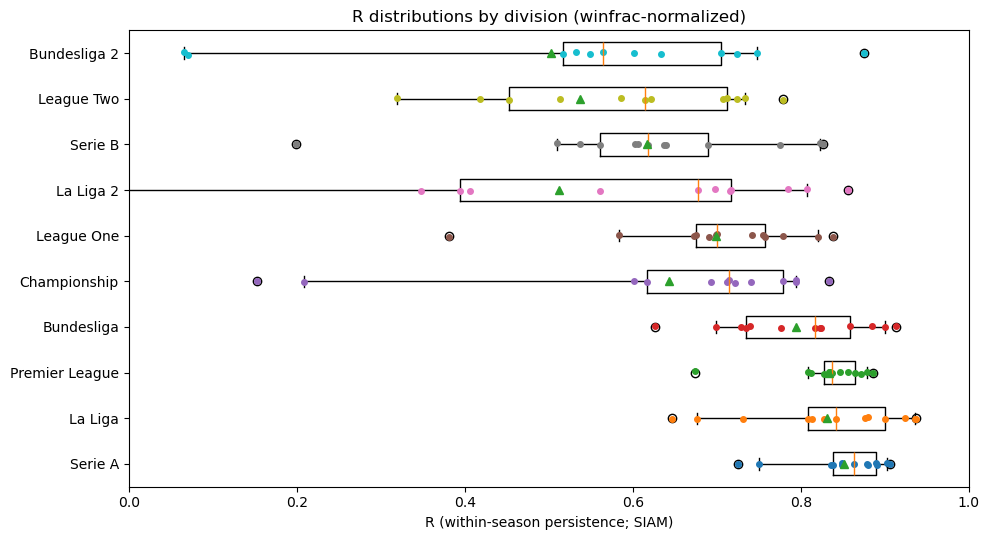

In [34]:
res_winfrac = compute_siam_R(data_dict, metric_mode="winfrac")
plot_siam_R_boxplot(res_winfrac, metric_mode="winfrac")

# 2. Ver2. Variance Decomposition Style (Don't need)


In [35]:
# Re-defining the R-value computation utilities (execution retry)
def _season_key(s):
    try:
        return int(str(s)[:4])
    except Exception:
        return s

def build_team_season_table(
    data_dict: Dict[str, Dict[str, pd.DataFrame]],
    points_win: int = 3, points_draw: int = 1, points_loss: int = 0
) -> pd.DataFrame:
    rows = []
    for season, div_map in data_dict.items():
        for division, df in div_map.items():
            needed = {"HomeTeam","AwayTeam","FTHG","FTAG"}
            if not needed.issubset(set(df.columns)):
                raise ValueError(f"{division} {season}: missing required columns {needed - set(df.columns)}")
            h = df.copy()
            h["team"] = h["HomeTeam"]
            h["gf"] = h["FTHG"]
            h["ga"] = h["FTAG"]
            a = df.copy()
            a["team"] = a["AwayTeam"]
            a["gf"] = a["FTAG"]
            a["ga"] = a["FTHG"]
            t = pd.concat([h[["team","gf","ga"]], a[["team","gf","ga"]]], ignore_index=True)
            outcome = np.sign(t["gf"] - t["ga"])
            pts = np.where(outcome>0, points_win, np.where(outcome==0, points_draw, points_loss))
            t["pts"] = pts
            t["gd"]  = t["gf"] - t["ga"]
            g = t.groupby("team", as_index=False).agg(pts=("pts","sum"),
                                                     gd=("gd","sum"),
                                                     mp=("pts","count"))
            g["division"] = division
            g["season"] = season
            rows.append(g[["division","season","team","pts","gd","mp"]])
    panel = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["division","season","team","pts","gd","mp"])
    return panel

def _adjacent_pairs(seasons: List[str]) -> List[Tuple[str,str]]:
    ss = sorted(seasons, key=_season_key)
    return list(zip(ss[:-1], ss[1:]))

def r_values_by_division(panel: pd.DataFrame, metric: str = "pts") -> Tuple[pd.DataFrame, pd.DataFrame]:
    if metric not in {"pts","gd"}:
        raise ValueError("metric must be 'pts' or 'gd'")
    details = []
    for division, df in panel.groupby("division"):
        seasons = df["season"].unique().tolist()
        for s0, s1 in _adjacent_pairs(seasons):
            a = df[df.season==s0][["team", metric]].rename(columns={metric: f"{metric}_t"})
            b = df[df.season==s1][["team", metric]].rename(columns={metric: f"{metric}_t1"})
            m = a.merge(b, on="team", how="inner")
            if len(m)>=3 and m[f"{metric}_t"].std(ddof=0)>0 and m[f"{metric}_t1"].std(ddof=0)>0:
                r = np.corrcoef(m[f"{metric}_t"], m[f"{metric}_t1"])[0,1]
                details.append({
                    "division": division,
                    "season_pair": f"{s0}→{s1}",
                    "metric": metric,
                    "teams_overlap": len(m),
                    "r": r
                })
    details_df = pd.DataFrame(details)
    if details_df.empty:
        return pd.DataFrame(columns=["division","metric","mean_r","pairs"]), details_df
    summary = details_df.groupby(["division","metric"], as_index=False).agg(mean_r=("r","mean"),
                                                                            pairs=("r","count"))
    return summary, details_df

def bootstrap_ci(x: np.ndarray, iters: int = 2000, alpha: float = 0.05, seed: int = 123) -> Tuple[float,float,float]:
    rng = np.random.default_rng(seed)
    x = np.array(x, dtype=float)
    if len(x)==0:
        return np.nan, np.nan, np.nan
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(iters)]
    mu = float(x.mean())
    lo = float(np.quantile(boots, alpha/2))
    hi = float(np.quantile(boots, 1-alpha/2))
    return mu, lo, hi

def r_values_with_ci(panel: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    out_rows = []
    all_details = []
    for metric in ["pts","gd"]:
        summary, details = r_values_by_division(panel, metric=metric)
        all_details.append(details)
        for _, row in summary.iterrows():
            div = row["division"]
            subset = details[(details["division"]==div) & (details["metric"]==metric)]["r"].values
            mu, lo, hi = bootstrap_ci(subset, iters=2000, alpha=0.05, seed=123)
            out_rows.append({"division": div, "metric": metric, "mean_r": mu, "ci_lo": lo, "ci_hi": hi, "pairs": len(subset)})
    return pd.DataFrame(out_rows), pd.concat(all_details, ignore_index=True) if len(all_details) else pd.DataFrame()

In [36]:
panel = build_team_season_table(data_dict, points_win=3, points_draw=1, points_loss=0)
summary_ci, details = r_values_with_ci(panel)

In [37]:
panel.head()

,division,season,team,pts,gd,mp
0,E0,2425,Arsenal,74,35.0,38
1,E0,2425,Aston Villa,66,7.0,38
2,E0,2425,Bournemouth,56,12.0,38
3,E0,2425,Brentford,56,9.0,38
4,E0,2425,Brighton,61,7.0,38


In [38]:
summary_ci.head()

,division,metric,mean_r,ci_lo,ci_hi,pairs
0,D1,pts,0.684068,0.599992,0.755390,12
1,D2,pts,0.310895,0.171048,0.446151,12
2,E0,pts,0.692852,0.612874,0.773651,12
3,E1,pts,0.355386,0.236528,0.453071,12
4,E2,pts,0.360465,0.252212,0.470849,12


In [39]:
details.head()

,division,season_pair,metric,teams_overlap,r
0,D1,1213→1314,pts,16,0.690200
1,D1,1314→1415,pts,16,0.793923
2,D1,1415→1516,pts,16,0.627234
3,D1,1516→1617,pts,16,0.720197
4,D1,1617→1718,pts,16,0.682761


In [40]:
panel['devision'] = panel['division'].map(divcode2divname)
summary_ci['division'] = summary_ci['division'].map(divcode2divname)
details['division'] = details['division'].map(divcode2divname)

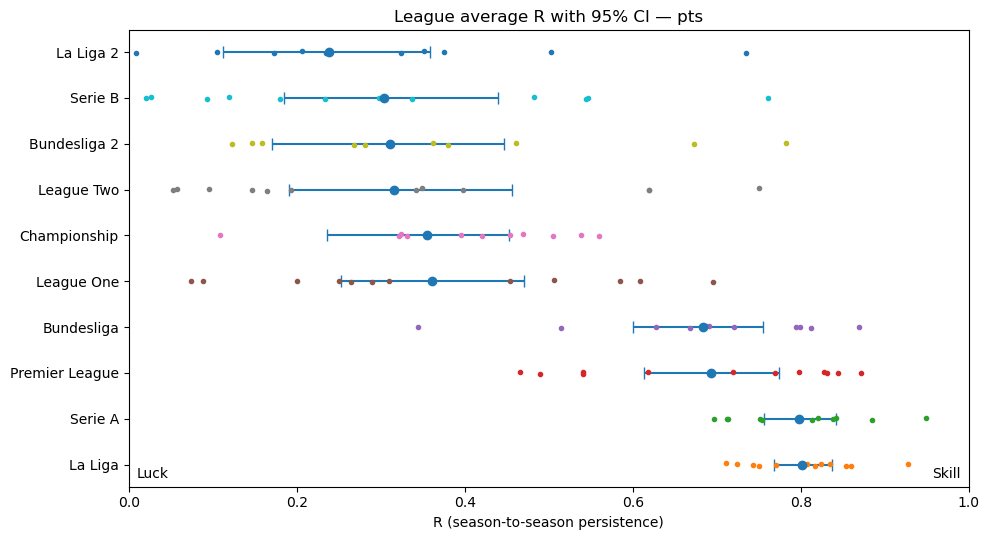

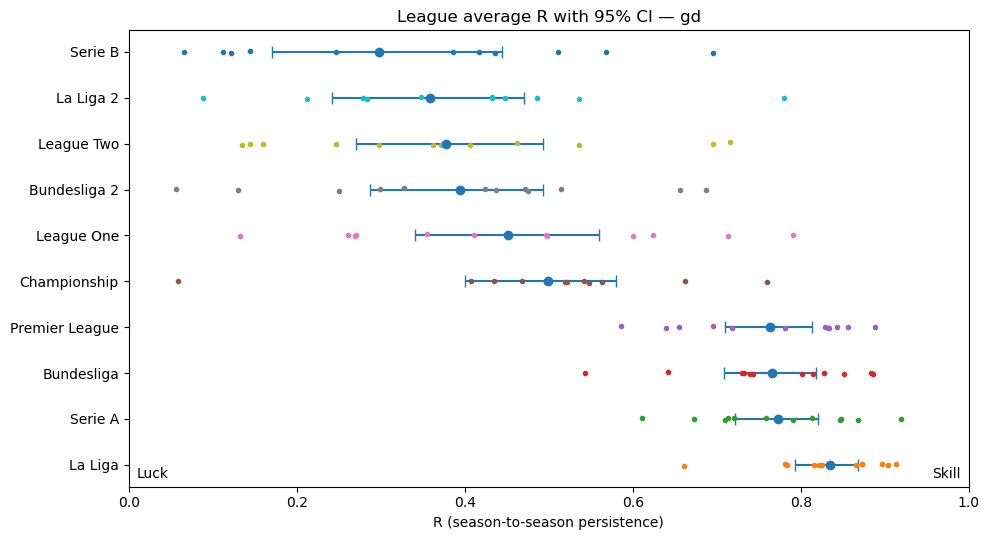

In [ ]:
def plot_siam_style_from_summary(summary_ci, details, metric="pts", outfile="/mnt/data/siam_style_R_{metric}.png"):
    
    s = summary_ci[summary_ci["metric"]==metric].copy()
    d = details[details["metric"]==metric].copy()
    if s.empty or d.empty:
        raise ValueError(f"No data for metric='{metric}'.")

    s = s.sort_values("mean_r", ascending=False).reset_index(drop=True)
    divisions = s["division"].tolist()
    y = np.arange(1, len(divisions)+1)

    means = s["mean_r"].values
    xerr = np.vstack([means - s["ci_lo"].values, s["ci_hi"].values - means])

    plt.figure(figsize=(10, 5.5))
    plt.errorbar(means, y, xerr=xerr, fmt='o', capsize=4)     # mean + 95% CI

    # Overlay season-pair r points (with light jitter)
    for yi, div in zip(y, divisions):
        vals = d[d["division"]==div]["r"].dropna().values
        if len(vals)==0: 
            continue
        xx = vals
        yy = np.full_like(vals, yi, dtype=float) + (np.random.rand(len(vals))-0.5)*0.06
        plt.plot(xx, yy, "o", markersize=3)

    plt.yticks(y, divisions)
    plt.xlim(0, 1)
    plt.xlabel("R (season-to-season persistence)")
    plt.title(f"League average R with 95% CI — {metric}")
    plt.annotate("Luck",  xy=(0.01, 0.02), xycoords=("axes fraction","axes fraction"))
    plt.annotate("Skill", xy=(0.99, 0.02), xycoords=("axes fraction","axes fraction"), ha="right")
    plt.tight_layout()
    # out = Path(outfile.format(metric=metric))
    # plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    # print("Saved to:", out)

# Run (save both charts: points/goal difference)
plot_siam_style_from_summary(summary_ci, details, metric="pts", outfile="/mnt/data/siam_style_R_{metric}.png")
plot_siam_style_from_summary(summary_ci, details, metric="gd",  outfile="/mnt/data/siam_style_R_{metric}.png")


# 3. Our Method (Generalized-R)

In [91]:
def update_elo(R_i, R_j, outcome_i, K=20, H=0):
    """단일 경기 후 Elo 업데이트."""
    E_i = 1.0 / (1 + 10 ** ((R_j - R_i + H) / 400))
    E_j = 1.0 - E_i
    R_i_new = R_i + K * (outcome_i - E_i)
    R_j_new = R_j + K * ((1 - outcome_i) - E_j)
    return R_i_new, R_j_new

def compute_elo_ratings(df, base_rating=1500, K=20):
    """시즌 내 모든 팀 Elo 추적 후, 각 경기마다 pre-match Elo를 기록."""
    teams = sorted(set(df["HomeTeam"]).union(set(df["AwayTeam"])))
    ratings = {t: base_rating for t in teams}
    pre_elos = []

    for _, row in df.sort_values("Date").iterrows():
        ht, at = row["HomeTeam"], row["AwayTeam"]
        hg, ag = row["FTHG"], row["FTAG"]

        if hg > ag: outcome_h = 1.0
        elif hg == ag: outcome_h = 0.5
        else: outcome_h = 0.0

        R_h, R_a = ratings[ht], ratings[at]
        pre_elos.append({"Date": row["Date"], "HomeTeam": ht, "AwayTeam": at,
                         "HomeElo": R_h, "AwayElo": R_a})

        new_R_h, new_R_a = update_elo(R_h, R_a, outcome_h, K=K)
        ratings[ht], ratings[at] = new_R_h, new_R_a

    pre_df = pd.DataFrame(pre_elos)
    df = df.merge(pre_df, on=["Date","HomeTeam","AwayTeam"], how="left")
    return df


def stratified_split(team_df, rng, eps=0.05, metric_mode="ppg"):
    """
    팀별 경기 기록을 두 fold(A,B)로 나눔.
    - 상대 Elo 분포가 균형되도록 stratify
    - 무작위 tie-breaking 포함
    """
    matches = team_df.copy()
    matches = matches.sort_values("Date")

    # 상대 Elo 가져오기
    opp_elos = []
    for _, row in matches.iterrows():
        if row["venue"] == "H":
            opp_elos.append(row["AwayElo"])
        else:
            opp_elos.append(row["HomeElo"])
    matches["opp_elo"] = opp_elos

    # Elo 기준으로 binning
    bins = pd.qcut(matches["opp_elo"], q=min(5, len(matches)), duplicates="drop")
    matches["elo_bin"] = bins

    A_idx, B_idx = [], []
    for _, g in matches.groupby("elo_bin"):
        idxs = g.index.tolist()
        rng.shuffle(idxs)
        half = len(idxs) // 2
        A_idx.extend(idxs[:half])
        B_idx.extend(idxs[half:])

    A = matches.loc[A_idx]
    B = matches.loc[B_idx]

    return A, B

def performance_metric(fold_df, metric_mode="ppg"):
    if len(fold_df) == 0:
        return np.nan
    if metric_mode == "ppg":
        pts = fold_df["pts"].sum()
        return (pts / len(fold_df)) / 3.0
    elif metric_mode == "winfrac":
        wins = fold_df["win"].sum()
        return wins / len(fold_df)
    else:
        raise ValueError("metric_mode must be 'ppg' or 'winfrac'")


def compute_generalized_R(data_dict, metric_mode="ppg", K=200, seed=123):
    rng = np.random.default_rng(seed)
    rows = []
    for season, divmap in data_dict.items():
        for division, df in divmap.items():
            # Elo ratings 사전 계산
            df = compute_elo_ratings(df)

            teams = sorted(set(df["HomeTeam"]).union(set(df["AwayTeam"])))
            XY_all = []
            for team in teams:
                trows = _team_rows(df, team)  # 앞에서 정의한 함수 재활용
                if len(trows) < 4:
                    continue
                # team별 K회 분할 반복
                for k in range(K):
                    A, B = stratified_split(trows, rng, metric_mode=metric_mode)
                    x = performance_metric(A, metric_mode)
                    y = performance_metric(B, metric_mode)
                    if np.isfinite(x) and np.isfinite(y):
                        XY_all.append((x,y))
            if len(XY_all) >= 3:
                X = np.array([u for u,v in XY_all])
                Y = np.array([v for u,v in XY_all])
                S = (X + Y)/np.sqrt(2)
                T = (Y - X)/np.sqrt(2)
                A_var = np.var(S, ddof=0)
                B_var = np.var(T, ddof=0)
                R = 1 - B_var/A_var if A_var > 1e-12 else np.nan
                rows.append({"division": division, "season": season, 
                             "metric_mode": metric_mode, "teams": len(teams), "R_g": R})
    return pd.DataFrame(rows)


In [119]:
data_dict.keys()

dict_keys(['2425', '2324', '2223', '2122', '2021'])

In [164]:
import warnings
warnings.filterwarnings("ignore")  # 모든 경고 숨기기

gen_r_ppg = compute_generalized_R(data_dict, metric_mode='ppg', K=3)

In [165]:
divcode2divname = {
    'E0': 'Premier League',
    'E1': 'EFL Championship',
    'E2': 'EFL League One',
    'E3': 'EFL League Two',
    "D1": "Bundesliga",
    "D2": "Bundesliga 2",
    "I1": "Serie A",
    "I2": "Serie B",
    "SP1": "La Liga",
    "SP2": "La Liga 2",
    "wc": "World Cup"
}
gen_r_ppg["division"] = gen_r_ppg["division"].map(divcode2divname)
gen_r_ppg

gen_r_ppg['R'] = gen_r_ppg['R_g']

In [169]:
gen_r_ppg

,division,season,metric_mode,teams,R_g,R
0,Premier League,2425,ppg,20,0.816399,0.816399
1,EFL Championship,2425,ppg,24,0.619333,0.619333
2,EFL League One,2425,ppg,24,0.813379,0.813379
3,EFL League Two,2425,ppg,24,0.441686,0.441686
4,Bundesliga,2425,ppg,18,0.792767,0.792767
5,Bundesliga 2,2425,ppg,18,0.462677,0.462677
6,Serie A,2425,ppg,20,0.797740,0.797740
7,Serie B,2425,ppg,20,0.768199,0.768199
8,La Liga,2425,ppg,20,0.790294,0.790294
9,La Liga 2,2425,ppg,22,0.670500,0.670500


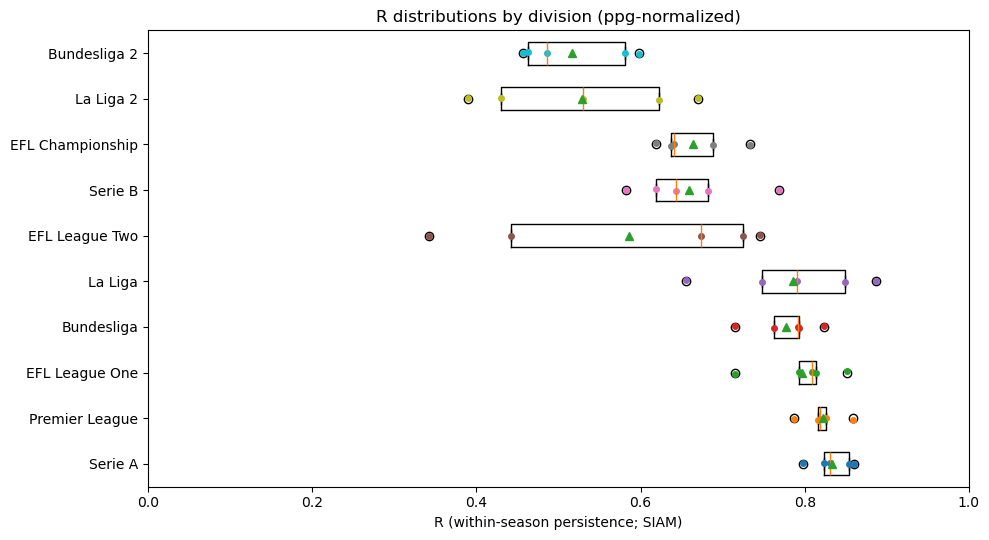

In [175]:
plot_siam_R_boxplot(gen_r_ppg[gen_r_ppg['division'] != "World Cup"], metric_mode="ppg")

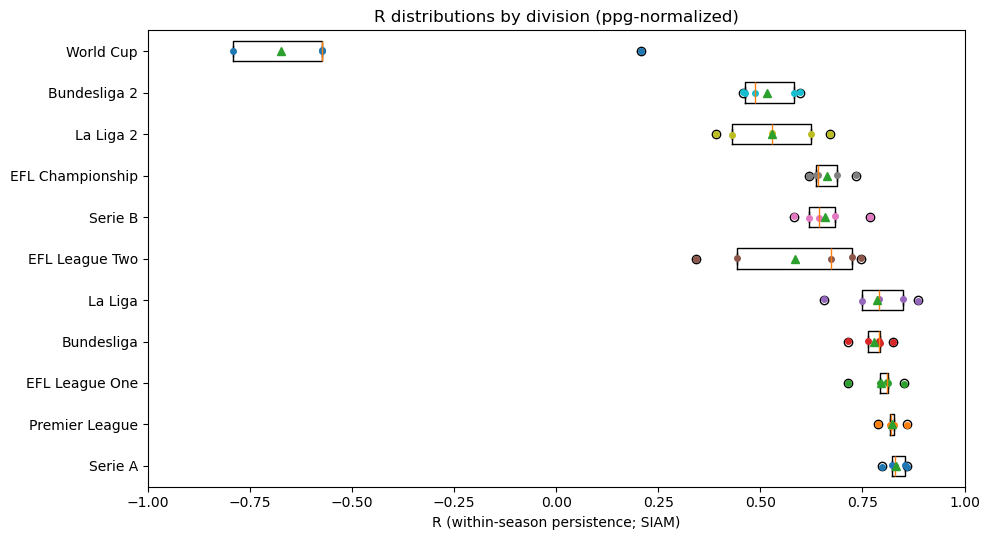

In [171]:
plot_siam_R_boxplot(gen_r_ppg, metric_mode="ppg")